In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score
import ipywidgets as widgets #For the slider feature
import scipy.stats as stats


from ipywidgets import interact,IntSlider



In [22]:
start="2020-01-01"
end="2023-12-01"

In [23]:
# Daily data

# clean_cols :Remove the Ticker row (previously: dataframe structure nested inside a dataframe).
def clean_cols(df): # Clean the multi-index columns from yfinance.

    df.columns = [c[0] for c in df.columns]
    return df

VIX=clean_cols(yf.download("^VIX",start, end))
sp500_v=clean_cols(yf.download("^GSPC",start, end))
sp500_v.head()



/tmp/ipython-input-3121680420.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX=clean_cols(yf.download("^VIX",start, end))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3121680420.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_v=clean_cols(yf.download("^GSPC",start, end))
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


# I. General visualisation

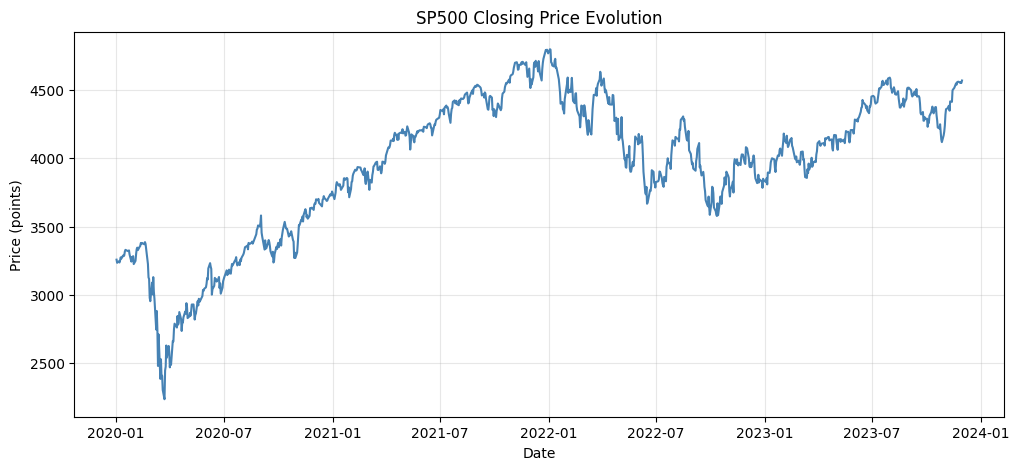

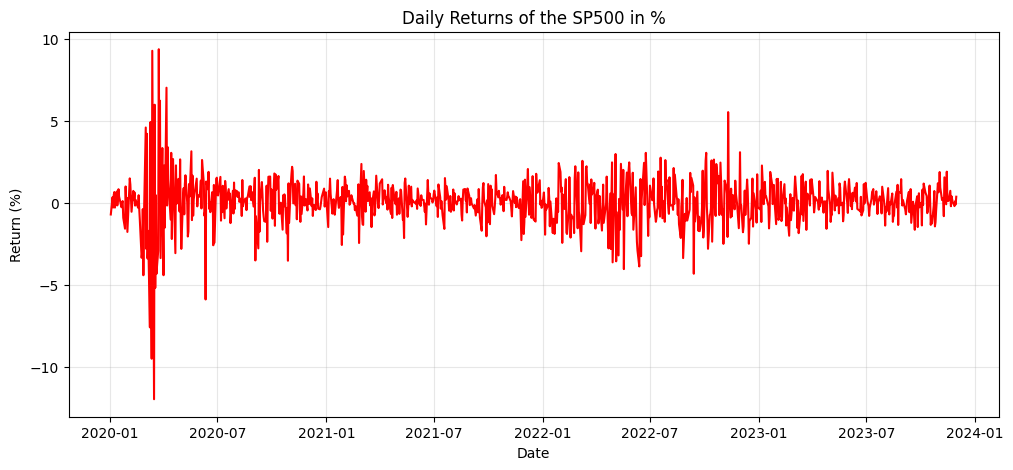

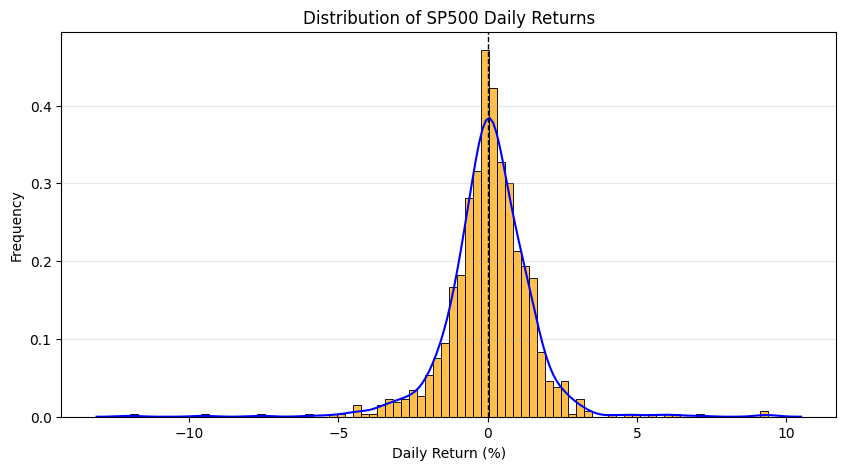

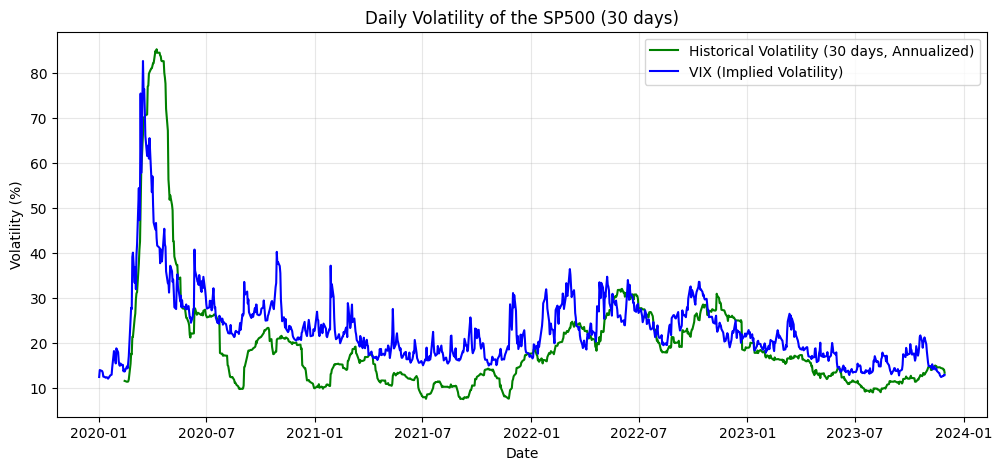

In [24]:
# Plot the Close of SP500
plt.figure(figsize=(12,5))
plt.plot(sp500_v["Close"], color="steelblue")
plt.title("SP500 Closing Price Evolution")
plt.xlabel("Date")
plt.ylabel("Price (points)")
plt.grid(True, alpha=0.3)
plt.show()


# Plot Returns: until the end of this notebook: returns="rendements"
plt.figure(figsize=(12,5))
sp500_v["rendements"]= (sp500_v["Close"]-sp500_v["Close"].shift(1))/sp500_v["Close"].shift(1)*100 # daily returns in % and shift(1) to offset by one day
sp500_v=sp500_v.dropna() # we remove the nan generated by the shift (we drop the first observation)
plt.plot(sp500_v["rendements"],color="red")
plt.title("Daily Returns of the SP500 in %")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.grid(True, alpha=0.3)
plt.show()

# Histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10,5))
sns.histplot(sp500_v["rendements"], bins=80, color="orange", edgecolor="black", alpha=0.7,stat="density") # histogram of daily returns
sns.kdeplot(sp500_v["rendements"],color="blue",label="KDE density") # KDE approximates the probability density (blue curve)
plt.title("Distribution of SP500 Daily Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.3)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

# Volatility

# rolling(window=30).std() * np.sqrt(252): apply a function over a 30-day rolling window (volatility: aggregation of returns over 30 days)
# sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252): computes the standard deviation of returns over a 30-day window and scales it to annualize volatility
sp500_v["vol_30j"]=sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252)   # there are 252 trading days per year and the VIX is annualized: we scale accordingly
sp500_v=sp500_v.dropna()
plt.figure(figsize=(12,5))
plt.plot(sp500_v["vol_30j"], color="green", label="Historical Volatility (30 days, Annualized)")
plt.title("Daily Volatility of the SP500 (30 days)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid(True, alpha=0.3)

# VIX
plt.plot(VIX["Close"], color="blue", label="VIX (Implied Volatility)") # VIX (on SP500): measures market-expected volatility

plt.legend()



# II. Analysis of the SP500

In [25]:
# retrieve information about the sp500 from a csv
sp500 = pd.read_csv("constituents (1).csv")
sp500 = sp500.drop(columns=["CIK", "Founded", "Date added", "Headquarters Location"])  # remove unnecessary columns
# CIK: central index key (unique identifier for companies registered with the SEC)
sp500.head()


,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [26]:
# we manually compute the weights of companies (very time-consuming: we need to retrieve the market cap of each company and then store it in the dataframe)

def get_marketcap(ticker): # retrieves the market capitalization of a company (number of shares × share price)
  try:

      # we have 2–3 tickers that differ between the two datasets, so we fix this:
      # replace BRK.B with BRK-B and BF.B with BF-B (due to missing data when calling info)
      if(ticker=="BRK.B"):
        ticker="BRK-B"
      if(ticker=="BF.B"):
        ticker="BF-B"

      info = yf.Ticker(ticker).info # retrieves company information via yfinance
      mc = info.get("marketCap", None) # specifically retrieves the market capitalization

      if mc is None: # if there is no market cap data, as for WBA
          print(f"No data for {ticker}")
      return mc

  except Exception as e:
      print(f"Error for {ticker}: {e}") # prints WBA because there is no market cap
      return None

sp500["MarketCap"] = sp500["Symbol"].apply(get_marketcap) # applies the get_marketcap function to each SP500 ticker
total_marketcap = sp500["MarketCap"].sum() # computes the total market capitalization of the SP500
sp500["Poids (%)"] = (sp500["MarketCap"] / total_marketcap) * 100 # percentage weight of each company in the SP500
sp500 = sp500.sort_values("Poids (%)", ascending=False) # sort for readability

sp500.head()


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}


No data for WBA


,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.580157e+12,6.937247
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",3.966243e+12,6.007393
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.833971e+12,5.807051
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.830634e+12,5.801997
316,MSFT,Microsoft,Information Technology,Systems Software,3.514773e+12,5.323583


We get a 404 error for WBA: never mind! It represents only about 0.2% of the total weight, so the lack of this information will not affect our analysis.

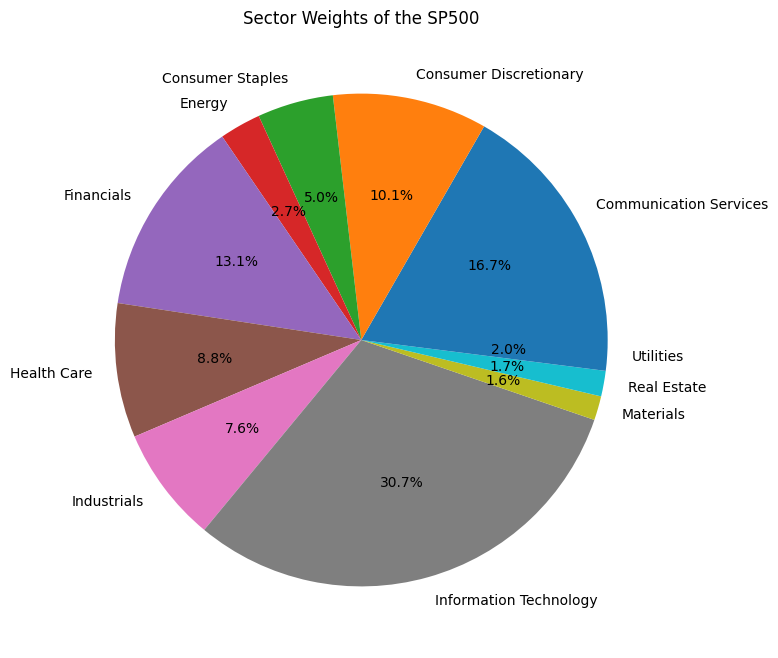

In [27]:
# pie chart: weights by sector
poids_secteurs = sp500.groupby("GICS Sector")["Poids (%)"].sum()  # groupby to get the total weight per sector
plt.figure(figsize=(8,8))
plt.pie(poids_secteurs, labels=poids_secteurs.index, autopct="%1.1f%%")  # autopct to display percentages; %1.1f%% means 1 digit before and 1 after the decimal
plt.title("Sector Weights of the SP500")
plt.show()


Les secteurs principaux sont: La tech, les services telecom/medias, la finance, l'industrie, la santé et "consumers discretionary qu'on va analyser plus tard.


Ces domaines dépendent de:

-L'énergie (mix électrique USA: petrole/gaz/charbon/nucléaire)
- Les matières premières (Métaux/Métaux précieux)
- Les taux directeurs (FED)
- La bonne santé de l'économie américaine car en plus d'être affectés par l'économie, ces domaines dépendent des éventuelles subventions (dur à déterminer)



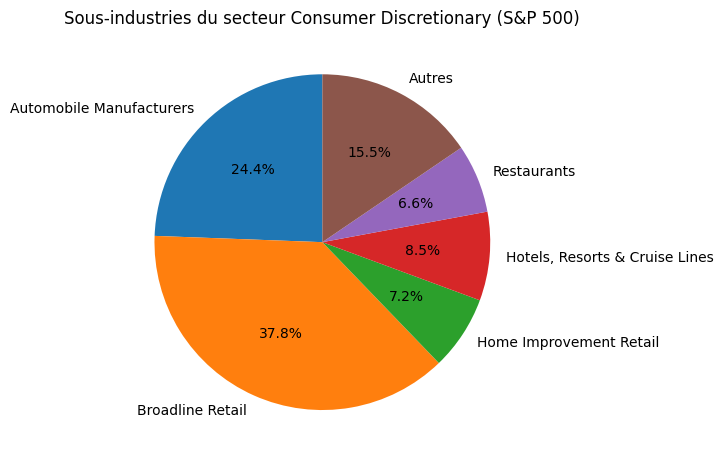

In [28]:
# on essaye de voir ce qu'il se passe dans le secteur Consumer Discretionary (car bcp de sous-industries : Automobiles, Hotels, broadling return Amazon)

consumer_disc = sp500[sp500["GICS Sector"] == "Consumer Discretionary"] # Filtrer les entreprises du secteur Consumer Discretionary
poids_secteurs_consumer_disc = consumer_disc.groupby("GICS Sub-Industry")["Poids (%)"].sum()

# Regrouper les sous-industries de moins de 0.5 % (par rapport au total) dans "Autres" pour avoir un camembert moins chargé
poids = poids_secteurs_consumer_disc.copy()
autres = poids[poids < 0.5].sum()
poids = poids[poids >= 0.5]
poids["Autres"] = autres # Ajouter la catégorie "Autres" pour les sous-industries moins représentées

# Camembert plus lisible
plt.figure(figsize=(7,7))
plt.pie(
    poids,
    labels=poids.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sous-industries du secteur Consumer Discretionary (S&P 500)")
plt.tight_layout()
plt.show()

On rajoute donc l'automobile qui rejoint l'industrie et les commerces (pas les supermarchés comme wallmart ect... car on est en dans des dépenses de confort)

In [29]:
# we also take the top 10 of the sp500:
top10 = sp500.sort_values("Poids (%)", ascending=False).head(10)  # retrieve the 10 companies with the highest weights
top10


,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.580157e+12,6.937247
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",3.966243e+12,6.007393
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.833971e+12,5.807051
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.830634e+12,5.801997
316,MSFT,Microsoft,Information Technology,Systems Software,3.514773e+12,5.323583
22,AMZN,Amazon,Consumer Discretionary,Broadline Retail,2.491462e+12,3.773644
310,META,Meta Platforms,Communication Services,Interactive Media & Services,1.660498e+12,2.515042
71,AVGO,Broadcom,Information Technology,Semiconductors,1.628248e+12,2.466195
439,TSLA,"Tesla, Inc.",Consumer Discretionary,Automobile Manufacturers,1.502173e+12,2.275237
59,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,1.075475e+12,1.628947


# III Addition of new data

In [30]:
# metals
cuivre = clean_cols(yf.download("HG=F", start,end))  # copper futures
aluminium = clean_cols(yf.download("ALI=F", start, end))
nickel = clean_cols(yf.download("JJN", start, end))       # JJN etf (used as a proxy due to lack of raw data)
zinc = clean_cols(yf.download("ZINC.L", start, end))      # etf

# precious metals
Or = clean_cols(yf.download("GC=F", start, end))  # safe haven asset, correlated with market crises; included here for presentation purposes
argent = clean_cols(yf.download("SI=F", start, end))

# energy
petrole = clean_cols(yf.download("CL=F", start, end))
gaz = clean_cols(yf.download("NG=F", start, end))
uranium = clean_cols(yf.download("URA", start, end))      # global x uranium etf (used as a proxy for raw data: from power plants to mining, nuclear energy etf)


/tmp/ipython-input-3200054615.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cuivre = clean_cols(yf.download("HG=F", start,end))  # copper futures
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3200054615.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aluminium = clean_cols(yf.download("ALI=F", start, end))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3200054615.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nickel = clean_cols(yf.download("JJN", start, end))       # JJN etf (used as a proxy due to lack of raw data)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3200054615.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  zinc = clean_cols(yf.download("ZINC.L", start, end))      # etf
[*********************100%**

In [31]:
# check whether everything is properly loaded
datasets = {
    "cuivre": cuivre,
    "aluminium": aluminium,
    "nickel": nickel,
    "zinc": zinc,
    "or": Or,
    "argent": argent,
    "petrole": petrole,
    "gaz": gaz,
    "uranium": uranium
}

for nom, df in datasets.items():
    if df is None or df.empty:
        print(f"{nom}: empty or not loaded")


In [32]:
# computation of returns for each dataset (returns="rendements")
def rdm(df):
    df["rendements"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
    return df.dropna(inplace=True)  # dropna to remove NaN values generated by the shift (dropna creates a new dataframe, inplace=True modifies the dataframe directly)


# apply the function to all datasets
for nom, df in datasets.items():
    rdm(df)

Or["rendements"].head()

,rendements
Date,
2020-01-03,1.620200
2020-01-06,1.097341
2020-01-07,0.357560
2020-01-08,-0.916149
2020-01-09,-0.365999


In [33]:
# regarding the us economic outlook, we will use 10-year treasury bonds

oblig_10ans = clean_cols(yf.download("^TNX", start, end))  # ^tnx: yield of us 10-year treasury bonds


/tmp/ipython-input-2703699041.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_10ans = clean_cols(yf.download("^TNX", start, end))  # ^tnx: yield of us 10-year treasury bonds
[*********************100%***********************]  1 of 1 completed


# IV correlation analysis and feature engineering

In [34]:
# we add the simple moving average (sma: simple moving average), not to be confused with vol_30j

def SMA(df, window):
    return df.rolling(window=window).mean()


# we also add the relative strength index (rsi: relative strength index):
# it measures the speed and magnitude of recent price changes, which is useful to identify strong upward or downward pressure


def RSI(data, dt):
    delta = data.diff()  # computes the difference between consecutive prices
    gain = (delta.where(delta > 0, 0)).rolling(window=dt).mean()  # average gains over the dt window
    loss = (-delta.where(delta < 0, 0)).rolling(window=dt).mean()  # average losses over the dt window

    rs = gain / loss  # relative strength is the ratio of average gains to average losses
    rsi = 100 - (100 / (1 + rs))  # rsi formula
    return rsi


rsi = RSI(sp500_v["Volume"], 14)   # for now, we use the "standard" value of 14 days. however, it might be interesting to use a shorter time scale to better reflect "market nervousness". we will optimize this later
sma = SMA(sp500_v["Volume"], 14)   # we also use a short-term sma (same window as the rsi for consistency and for the reasons mentioned above)
# sma: rolling average (sum of prices / n)
# rsi: upward or downward pressure
sma.head()  # many NaNs since this is not yet merged with the main dataframe; we will handle this during the merge
sma.tail()



,Volume
Date,
2023-11-24,3.621189e+09
2023-11-27,3.603164e+09
2023-11-28,3.588521e+09
2023-11-29,3.637754e+09
2023-11-30,3.744791e+09


We create 13 missing values because the indicators are computed over a rolling window. Ideally, all transformations (returns, vol_30j, rsi, etc.) should be performed at the same time to avoid accumulating too many missing values. However, for the sake of clarity and presentation, we will keep the notebook as it is. Given the large amount of data, the loss is negligible.

It is time to compute our first correlation measures:

In [35]:
# we create functions to generate correlation matrices with a temporal slider
def ensure_data_range(start_year, end_year, df_dict):
    # convert input years to timestamps (timestamp because this is the format of our "Date" index)
    requested_start = pd.Timestamp(f"{start_year}-01-01")
    requested_end   = pd.Timestamp(f"{end_year}-12-31")

    # for each dataframe:
    for name, df in df_dict.items():
        # check whether the data has already been downloaded; if not, download it
        if requested_start < df.index.min() or requested_end > df.index.max():
            print(f"downloading {name}…")
            df_new = clean_cols(
                yf.download(name, "2000-01-01", "2023-12-31")
            ).dropna()
            rdm(df_new)
            df_dict[name] = df_new

    return df_dict


_last_call = None
_initialized = False


def plot_corr(start_year, end_year, df_dict, rename_dict=None, title="correlation"):

    global _last_call, _initialized

    key = (
        min(start_year, end_year),
        max(start_year, end_year),
        title
    )

    # guard only AFTER the first display
    if _initialized and key == _last_call:
        return

    _last_call = key
    _initialized = True

    # fix if dates are inverted
    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)

    df_concat = pd.concat(
        {i: j["Close"] for i, j in df_dict.items()},
        axis=1
    )

    # extract the requested period from df_concat
    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"

    final_df = df_concat.loc[start:end].dropna()

    # ensure we have enough data
    if len(final_df) < 30:
        print("interval too short.")
        return

    corr = final_df.corr()

    # rename variables
    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')  # prevents duplicate plots
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()


# same functions applied to returns
def plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title="correlation"):
    global _last_call
    key = (start_year, end_year)
    if key == _last_call:
        return
    _last_call = key

    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)

    df_concat = pd.concat(
        {i: j["rendements"] for i, j in df_dict.items()},
        axis=1
    )

    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"

    final_df = df_concat.loc[start:end].dropna()

    if len(final_df) < 30:
        print("interval too short.")
        return

    corr = final_df.corr()

    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()


A)On the closing price

In [36]:
# correlations between commodities and the vix:
commos = {
    "^VIX": VIX,
    "HG=F": cuivre,
    "ALI=F": aluminium,
    "JJN": nickel,
    "ZINC.L": zinc,
    "GC=F": Or,
    "SI=F": argent,
}

rename_commo = {
    "^VIX": "VIX",
    "HG=F": "Copper",
    "GC=F": "Gold",
    "SI=F": "Silver",
    "ZINC.L": "Zinc ETF",
    "ALI=F": "Aluminum",
    "JJN": "Nickel ETF"
}

# widget usage
interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1, continuous_update=False),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1, continuous_update=False),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Correlation with Commodities (Close)")
)


interactive(children=(IntSlider(value=2020, continuous_update=False, description='start_year', max=2023, min=2…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

We observe some interesting correlations, notably with silver, gold, and aluminum (as well as copper to a lesser extent).

Since silver and gold are themselves highly correlated (the same applies to copper and aluminum), we will simplify the analysis by keeping only silver and copper.

B) On returns

In [37]:

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Correlation with commos (Returns)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

We observe that closing prices show interesting correlations, whereas returns exhibit almost none: this is completely normal.

Returns, which represent daily variations, are often chaotic and tend to follow a normal distribution (see the visualizations at the beginning of the notebook). Therefore, it is not surprising to find little to no correlation (unfortunately!).

On the other hand, prices (closing prices), although they exhibit inflated correlations due to a common trend in a global market, should not be neglected. Moreover, they embed historical information that is, to some extent, reflected in investors’ expectations.

That said, this may introduce bias into the model. We will correct for this if necessary.

# We do the same with energy

In [38]:
# correlations between commodities and the vix:
# energy

energies = {
    "^VIX": VIX,
    "NG=F": gaz,
    "URA": uranium,
    "CL=F": petrole
}

rename_energies = {
    "^VIX": "VIX",
    "NG=F": "Natural Gas",
    "URA": "Uranium ETF",
    "CL=F": "Oil"
}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Correlation with Energy (Close)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

In [39]:
interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Correlation with Energy (Returns)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

We note an interesting relationship with uranium, even in returns! This may be because it is an ETF tracking the industry itself.

We will keep it.

In [40]:
# correlations between bonds and the vix
rdm(oblig_10ans)

gouvernerment = {
    "^VIX": VIX,
    "^TNX": oblig_10ans
}

rename_gouvernement = {
    "^VIX": "VIX",
    "^TNX": "10-year Treasury Bonds"
}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Correlation with US Bonds (Close)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

In [41]:
interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Correlation with US Bonds (Returns)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

We are onto something, but it is not quite there yet. Let’s try a shorter maturity to better capture the impact of recent decisions.

Let’s use 3-month Treasury bills.

In [42]:
oblig_3mois = clean_cols(yf.download("^IRX", start, end))

# correlations between bonds and the vix
rdm(oblig_3mois)

gouvernerment = {
    "^VIX": VIX,
    "^TNX": oblig_10ans,
    "^IRX": oblig_3mois
}

rename_gouvernement = {
    "^VIX": "VIX",
    "^TNX": "10-year Treasury Bonds",
    "^IRX": "3-month Treasury Bills"
}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Correlation with US Bonds (Close)")
)


/tmp/ipython-input-3232457884.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_3mois = clean_cols(yf.download("^IRX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

L'oblig à court terme n'apporte rien visiblement

Avec le SP500:

In [43]:
# correlations between the sp500 and the vix:

# here, sma and rsi are only valid starting from the chosen start year: to be corrected
sp500_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "SP500": sp500_v["Close"],
    "SP500 Vol": sp500_v["Volume"],
    "SP500 SMA": sma,
    "SP500 RSI": rsi
}).dropna()


interact(
    lambda start_year, end_year: sns.heatmap(
        sp500_df.loc[f"{start_year}-01-01":f"{end_year}-12-31"].corr(),
        annot=True, cmap="coolwarm", center=0
    ) or plt.title(f"Correlation VIX / SP500 ({start_year} → {end_year})") or plt.show(),

    start_year=IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=IntSlider(value=2023, min=2000, max=2023, step=1)
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.<lambda>(start_year, end_year)>

We also import the VVIX (implied volatility of the VIX).

In [44]:
VVIX = clean_cols(yf.download("^VVIX", start, end))

VolImplciteVIX = {
    "^VIX": VIX,
    "^VVIX": VVIX
}

rename_VolImpliciteVIX = {
    "^VIX": "VIX",
    "^VVIX": "VVIX"
}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Correlation with VVIX (Close)")
)






/tmp/ipython-input-1644987937.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VVIX = clean_cols(yf.download("^VVIX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

In [45]:
rdm(VVIX)

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Correlation with VVIX (returns)")
)



interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='correlation')>

In conclusion, we will keep:

Commodities: Aluminum, Gold, Silver
Energy: Uranium, Oil
Government: 10-year Treasury bonds
SP500: Close, Volume, SMA, RSI
Other indices: VVIX


## V) Models Elaboration

In [46]:
rdm(VIX)  # create the missing returns column for the vix

model1_df = pd.DataFrame({
    "VIX_Close": VIX["Close"],
    "VVIX_Close": VVIX["Close"],

    "SP500_Close": sp500_v["Close"],
    "SP500_Volume": sp500_v["Volume"],
    "SMA30": sma,
    "RSI14": rsi,

    "Or_Close": Or["Close"],
    "Argent_Close": argent["Close"],
    "Aluminium_Close": aluminium["Close"],

    "Uranium_Close": uranium["Close"],
    "Petrole_Close": petrole["Close"],

    "Taux10_Close": oblig_10ans["Close"],

    # returns (taken from source dataframes)
    "SP500_ret": sp500_v["rendements"],
    "Or_ret": Or["rendements"],
    "Argent_ret": argent["rendements"],
    "Aluminium_ret": aluminium["rendements"],
    "Uranium_ret": uranium["rendements"],
    "Petrole_ret": petrole["rendements"],
    "Taux10_ret": oblig_10ans["rendements"],
    "VIX_ret": VIX["rendements"],
    "VVIX_ret": VVIX["rendements"],
})

model1_df = model1_df.dropna()
model1_df.head()


,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Or_Close,Argent_Close,Aluminium_Close,Uranium_Close,...,Taux10_Close,SP500_ret,Or_ret,Argent_ret,Aluminium_ret,Uranium_ret,Petrole_ret,Taux10_ret,VIX_ret,VVIX_ret
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,39.619999,119.660004,3023.939941,5.579290e+09,5.263519e+09,60.940050,1666.400024,17.341999,1709.25,8.081609,...,0.926,-3.392208,1.541652,0.901837,-0.697168,-0.691011,-1.881140,-6.653224,23.851201,4.992544
2020-03-06,41.939999,127.160004,2972.370117,6.555240e+09,5.487486e+09,64.454742,1670.800049,17.214001,1675.25,7.993241,...,0.706,-1.705385,0.264044,-0.738083,-1.989177,-1.093439,-10.065365,-23.758102,5.855628,6.267758
2020-03-09,54.459999,137.190002,2746.560059,8.441290e+09,5.822549e+09,68.912728,1674.500000,17.000999,1660.75,7.213999,...,0.499,-7.596970,0.221448,-1.237372,-0.865542,-9.748762,-24.588178,-29.320109,29.852172,7.887699
2020-03-10,47.299999,138.820007,2882.229980,7.642040e+09,6.110252e+09,65.415256,1659.099976,16.906000,1686.00,7.527302,...,0.748,4.939631,-0.919679,-0.558787,1.520397,4.342980,10.375848,49.899801,-13.147264,1.188137
2020-03-11,53.900002,146.929993,2741.379883,7.431200e+09,6.353968e+09,63.255381,1641.400024,16.729000,1681.00,7.222033,...,0.820,-4.886845,-1.066841,-1.046966,-0.296560,-4.055487,-4.016301,9.625664,13.953493,5.842087


Some assets are highly correlated with each other (such as gold and silver), so we will proceed with a PCA (principal component analysis).

In [47]:
print(model1_df[["Petrole_Close", "Uranium_Close"]].corr(),"\n")
print(model1_df[["Or_Close", "Argent_Close"]].corr())


               Petrole_Close  Uranium_Close
Petrole_Close       1.000000       0.824759
Uranium_Close       0.824759       1.000000 

              Or_Close  Argent_Close
Or_Close      1.000000      0.631597
Argent_Close  0.631597      1.000000


In [48]:
# target: next-day vix
model1_df["VIX_target"] = model1_df["VIX_Close"].shift(-1)
model1_df = model1_df.dropna()

y = model1_df["VIX_Close"]                     # target
X = model1_df.drop(columns=["VIX_Close"])

# split without shuffling the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)  # shuffle=False to avoid biasing the model (otherwise we would predict the future using future data)


In [49]:
# PCA 1: Gold / Silver
metal_cols = ["Or_Close", "Argent_Close"]

# --- train / test data ---
df_metalp_train = X_train[metal_cols].dropna()
df_metalp_test  = X_test[metal_cols].dropna()

# --- standardization (FIT ON TRAIN) ---
scaler_metal = StandardScaler()
X_metal_scaled_train = scaler_metal.fit_transform(df_metalp_train)
X_metal_scaled_test  = scaler_metal.transform(df_metalp_test)

# --- PCA (FIT ON TRAIN) ---
pca_metalp = PCA(n_components=2)
X_metal_pca_train = pca_metalp.fit_transform(X_metal_scaled_train)
X_metal_pca_test  = pca_metalp.transform(X_metal_scaled_test)

# --- explained variance (on the training set) ---
print("Explained variance:", pca_metalp.explained_variance_ratio_)

# --- descriptive correlation (OK on full X) ---
df_metalp = X[metal_cols].dropna()
corr_metalp = df_metalp.corr().iloc[0, 1]

print(f"Gold–Silver correlation: {corr_metalp:.3f}")
print(f"PC1 (common factor): {pca_metalp.explained_variance_ratio_[0]*100:.1f}% of explained variance")
print(f"PC2 (Gold vs Silver spread): {pca_metalp.explained_variance_ratio_[1]*100:.1f}% of explained variance")


Explained variance: [0.8517223 0.1482777]
Gold–Silver correlation: 0.632
PC1 (common factor): 85.2% of explained variance
PC2 (Gold vs Silver spread): 14.8% of explained variance


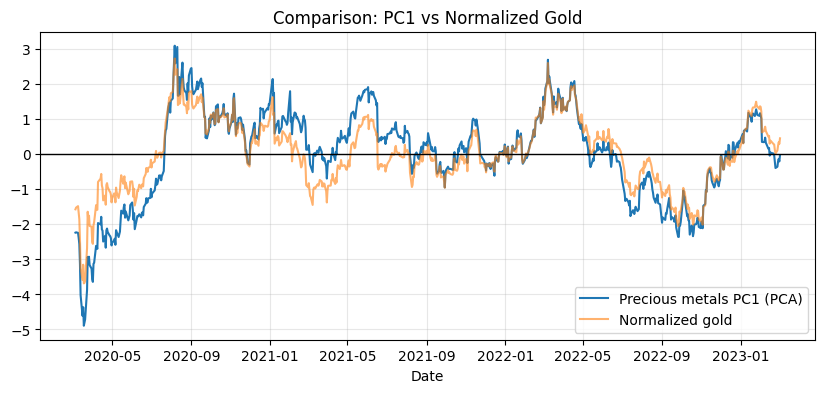

Correlation PC2 / standardized spread: 0.411


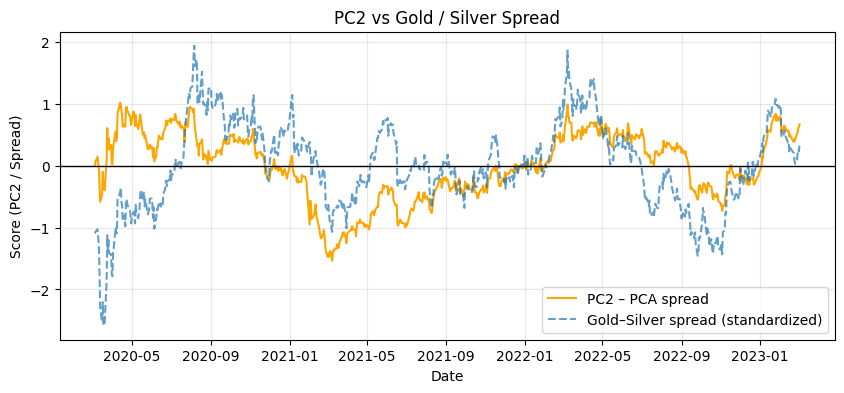

In [50]:
# PC1 and PC2 over time
metal_pc1 = pd.Series(X_metal_pca_train[:, 0], index=df_metalp_train.index, name="Metal_PC1")
metal_pc2 = pd.Series(X_metal_pca_train[:, 1], index=df_metalp_train.index, name="Metal_PC2")


# PC1 vs Gold (normalized)
plt.figure(figsize=(10, 4))
plt.plot(metal_pc1, label="Precious metals PC1 (PCA)")
plt.plot(
    (df_metalp_train["Or_Close"] - df_metalp_train["Or_Close"].mean()) /
    df_metalp_train["Or_Close"].std(),
    label="Normalized gold", alpha=0.6
)
plt.axhline(0, color='black', linewidth=1)
plt.title("Comparison: PC1 vs Normalized Gold")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



# PC2 vs Spread (Gold–Silver)


# Standardized spread
spread_std = (
    (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]) -
    (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]).mean()
) / (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]).std()

spread_std = spread_std / np.sqrt(2)  # same scale as PC2 (in our PCA we divide by 1/2)
spread_std.name = "Gold–Silver Spread"

# Correlation
corr_pc2_spread = metal_pc2.corr(spread_std)
print(f"Correlation PC2 / standardized spread: {corr_pc2_spread:.3f}")

# Comparison plot
plt.figure(figsize=(10, 4))
plt.plot(metal_pc2, label="PC2 – PCA spread", color="orange")
plt.plot(spread_std, label="Gold–Silver spread (standardized)", linestyle="--", alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title("PC2 vs Gold / Silver Spread")
plt.xlabel("Date")
plt.ylabel("Score (PC2 / Spread)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [51]:
# PCA 2: Oil / Uranium
energy_cols = ["Petrole_Close", "Uranium_Close"]

# --- train / test data ---
df_energy_train = X_train[energy_cols].dropna()
df_energy_test  = X_test[energy_cols].dropna()

# --- standardization (FIT ON TRAIN) ---
scaler_energy = StandardScaler()
X_energy_scaled_train = scaler_energy.fit_transform(df_energy_train)
X_energy_scaled_test  = scaler_energy.transform(df_energy_test)

# --- PCA (FIT ON TRAIN) ---
pca_energy = PCA(n_components=2)
X_energy_pca_train = pca_energy.fit_transform(X_energy_scaled_train)
X_energy_pca_test  = pca_energy.transform(X_energy_scaled_test)

print("Explained variance (energy):", pca_energy.explained_variance_ratio_, "\n")

# Results
df_energy = X[energy_cols].dropna()
corr_energy = df_energy.corr().iloc[0, 1]

print(f"Oil–Uranium correlation: {corr_energy:.3f}")
print(f"PC1 (common ENERGY factor): {pca_energy.explained_variance_ratio_[0]*100:.1f}% of explained variance")
print(f"PC2 (Oil vs Uranium spread): {pca_energy.explained_variance_ratio_[1]*100:.1f}% of explained variance")


Explained variance (energy): [0.92361685 0.07638315] 

Oil–Uranium correlation: 0.826
PC1 (common ENERGY factor): 92.4% of explained variance
PC2 (Oil vs Uranium spread): 7.6% of explained variance


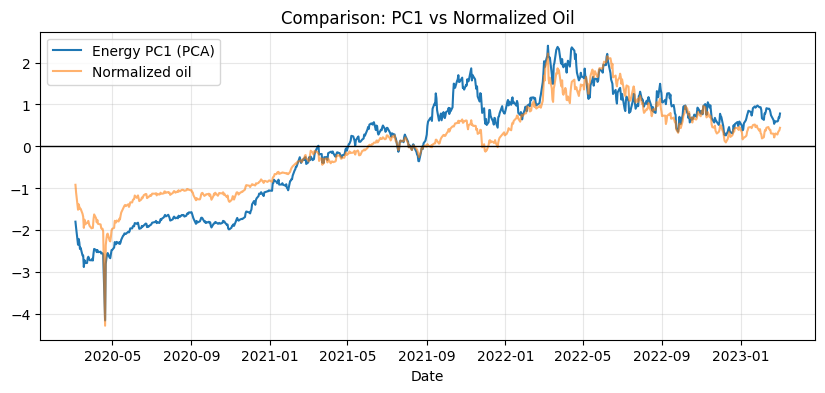

Correlation PC2 / standardized spread: 0.390


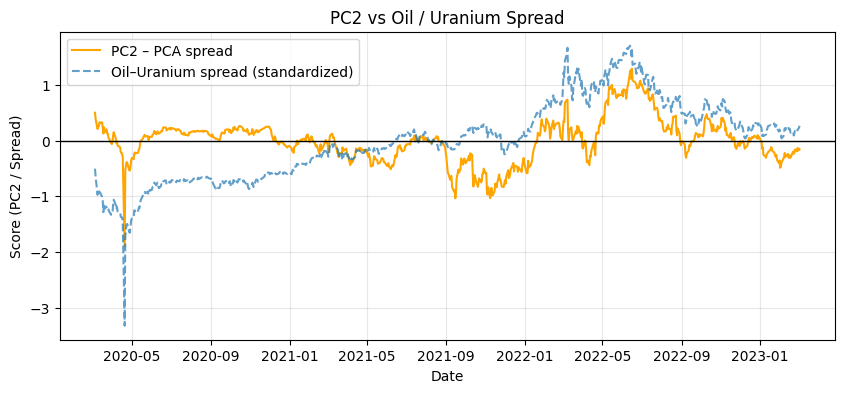

In [52]:
# PC1 and PC2 over time
energie_pc1 = pd.Series(
    X_energy_pca_train[:, 0],
    index=df_energy_train.index,
    name="Energie_PC1"
)
energie_pc2 = pd.Series(
    X_energy_pca_train[:, 1],
    index=df_energy_train.index,
    name="Energie_PC2"
)

# PC1 vs Oil (normalized)
plt.figure(figsize=(10, 4))
plt.plot(energie_pc1, label="Energy PC1 (PCA)")
plt.plot(
    (df_energy_train["Petrole_Close"] - df_energy_train["Petrole_Close"].mean()) /
    df_energy_train["Petrole_Close"].std(),
    label="Normalized oil", alpha=0.6
)
plt.axhline(0, color='black', linewidth=1)
plt.title("Comparison: PC1 vs Normalized Oil")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



# PC2 vs Spread (Oil vs Uranium)


# Standardized spread
spread_std = (
    (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]) -
    (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]).mean()
) / (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]).std()

spread_std = spread_std / np.sqrt(2)  # same scale as PC2 (in our PCA we divide by 1/2)
spread_std.name = "Oil–Uranium Spread"

# Correlation
corr_pc2_spread = energie_pc2.corr(spread_std)
print(f"Correlation PC2 / standardized spread: {corr_pc2_spread:.3f}")

# Comparison plot
plt.figure(figsize=(10, 4))
plt.plot(energie_pc2, label="PC2 – PCA spread", color="orange")
plt.plot(spread_std, label="Oil–Uranium spread (standardized)", linestyle="--", alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title("PC2 vs Oil / Uranium Spread")
plt.xlabel("Date")
plt.ylabel("Score (PC2 / Spread)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [53]:
# Metals: Gold / Silver
metal_pc1 = pd.concat([
    pd.Series(X_metal_pca_train[:, 0], index=df_metalp_train.index),
    pd.Series(X_metal_pca_test[:, 0], index=df_metalp_test.index)
]).sort_index()
metal_pc1.name = "Metal_PC1"

metal_pc2 = pd.concat([
    pd.Series(X_metal_pca_train[:, 1], index=df_metalp_train.index),
    pd.Series(X_metal_pca_test[:, 1], index=df_metalp_test.index)
]).sort_index()
metal_pc2.name = "Metal_PC2"


# Energy: Oil / Uranium
energy_pc1 = pd.concat([
    pd.Series(X_energy_pca_train[:, 0], index=df_energy_train.index),
    pd.Series(X_energy_pca_test[:, 0], index=df_energy_test.index)
]).sort_index()
energy_pc1.name = "Energy_PC1"

energy_pc2 = pd.concat([
    pd.Series(X_energy_pca_train[:, 1], index=df_energy_train.index),
    pd.Series(X_energy_pca_test[:, 1], index=df_energy_test.index)
]).sort_index()
energy_pc2.name = "Energy_PC2"


model1_df_acp = model1_df.copy()

# Replace original features with the new PCA features
model1_df_acp["Metal_PC1"] = metal_pc1
model1_df_acp["Metal_PC2"] = metal_pc2
model1_df_acp["Energy_PC1"] = energy_pc1
model1_df_acp["Energy_PC2"] = energy_pc2

cols_to_drop = ["Or_Close", "Argent_Close", "Petrole_Close", "Uranium_Close"]
model1_df_acp = model1_df_acp.drop(columns=cols_to_drop)

# Clean potential missing values
model1_df_acp = model1_df_acp.dropna()

model1_df_acp.head()


,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Aluminium_Close,Taux10_Close,SP500_ret,Or_ret,...,Uranium_ret,Petrole_ret,Taux10_ret,VIX_ret,VVIX_ret,VIX_target,Metal_PC1,Metal_PC2,Energy_PC1,Energy_PC2
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,39.619999,119.660004,3023.939941,5.579290e+09,5.263519e+09,60.940050,1709.25,0.926,-3.392208,1.541652,...,-0.691011,-1.881140,-6.653224,23.851201,4.992544,41.939999,-2.235205,0.013683,-1.792504,0.499457
2020-03-06,41.939999,127.160004,2972.370117,6.555240e+09,5.487486e+09,64.454742,1675.25,0.706,-1.705385,0.264044,...,-1.093439,-10.065365,-23.758102,5.855628,6.267758,54.459999,-2.226929,0.075046,-1.937027,0.381162
2020-03-09,54.459999,137.190002,2746.560059,8.441290e+09,5.822549e+09,68.912728,1660.75,0.499,-7.596970,0.221448,...,-9.748762,-24.588178,-29.320109,29.852172,7.887699,47.299999,-2.241819,0.148496,-2.341367,0.208097
2020-03-10,47.299999,138.820007,2882.229980,7.642040e+09,6.110252e+09,65.415256,1686.00,0.748,4.939631,-0.919679,...,4.342980,10.375848,49.899801,-13.147264,1.188137,53.900002,-2.383388,0.046327,-2.203001,0.253477
2020-03-11,53.900002,146.929993,2741.379883,7.431200e+09,6.353968e+09,63.255381,1681.00,0.820,-4.886845,-1.066841,...,-4.055487,-4.016301,9.625664,13.953493,5.842087,75.470001,-2.560162,-0.057038,-2.287554,0.259526


In [54]:
# final X / y split after PCA (prediction of VIX at t+1)
y_acp = model1_df_acp["VIX_target"]
X_acp = model1_df_acp.drop(columns=["VIX_Close", "VIX_target"])

# realignment with the initial split (temporal split preserved)
X_train_acp = X_acp.loc[X_train.index.intersection(X_acp.index)]
X_test_acp  = X_acp.loc[X_test.index.intersection(X_acp.index)]

y_train_acp = y_acp.loc[X_train_acp.index]
y_test_acp  = y_acp.loc[X_test_acp.index]

# standardization (fit on training set only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_acp)
X_test_scaled  = scaler.transform(X_test_acp)


In [55]:
model1_linear = LinearRegression()
model1_linear.fit(X_train_scaled, y_train_acp)

y_pred_linear1 = model1_linear.predict(X_test_scaled)

MSE_linear1 = mean_squared_error(y_test_acp, y_pred_linear1)
print("MSE Regression linéaire: ", MSE_linear1, "\n")

RMSE_linear1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_linear1))
print("RMSE :", RMSE_linear1, "\n")

R2_linear1 = r2_score(y_test_acp, y_pred_linear1)
print("R2 score: ", R2_linear1)




MSE Regression linéaire:  6.712555433913724 

RMSE : 2.590859979604016 

R2 score:  0.20395709891874114


In [56]:
model1_forestreg = RandomForestRegressor()
model1_forestreg.fit(X_train_scaled, y_train_acp)

y_pred_forestreg1 = model1_forestreg.predict(X_test_scaled)

MSE_forestreg1 = mean_squared_error(y_test_acp, y_pred_forestreg1)
print("MSE Random Forest Reg: ", MSE_forestreg1, "\n")

RMSE_forestreg1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_forestreg1))
print("RMSE :", RMSE_forestreg1, "\n")

R2_forestreg1 = r2_score(y_test_acp, y_pred_forestreg1)
print("R2 score: ", R2_forestreg1)




MSE Random Forest Reg:  26.662995195881773 

RMSE : 5.163622294076299 

R2 score:  -2.1619683824153277


In [57]:
model1_gradient = GradientBoostingRegressor()
model1_gradient.fit(X_train_scaled, y_train_acp)

y_pred_gradient1 = model1_gradient.predict(X_test_scaled)

MSE_gradient1 = mean_squared_error(y_test_acp, y_pred_gradient1)
print("MSE Gradient Boosting: ", MSE_gradient1, "\n")

RMSE_gradient1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_gradient1))
print("RMSE :", RMSE_gradient1, "\n")

R2_gradient1 = r2_score(y_test_acp, y_pred_gradient1)
print("R2 score: ", R2_gradient1)


MSE Gradient Boosting:  18.634661387385506 

RMSE : 4.316788318574992 

R2 score:  -1.2098871372496638


our models perform very poorly; there is no point in running hyperparameter searches.we will improve the model: since this is a time series, it would be useful to add a "history" of past prices.


New Model:

In [58]:
model2_df = model1_df_acp.copy()
#Ici nous allons ajouter un "historique" qui donnera les prix passés dans chaque colonne sur 1,5,10 et 30 jours

#VIX
for lag in [1, 5, 10, 30]:
    model2_df[f"VIX_lag_{lag}"] = model2_df["VIX_Close"].shift(lag)

#Rendements SP500
for lag in [1, 5, 10, 30]:
    model2_df[f"SP500_ret_lag_{lag}"] = model2_df["SP500_ret"].shift(lag)

#Volatilité réalisée
for window in [5, 10, 20, 30]:
    model2_df[f"RV_{window}"] = model2_df["SP500_ret"].rolling(window).std()

#VVIX
for lag in [1, 5, 10, 30]:
    model2_df[f"VVIX_lag_{lag}"] = model2_df["VVIX_Close"].shift(lag)

#SP500 drawdown (pire perte): comme notre VIX est l'indice de la peur cela est très pertinent
rolling_max = model2_df["SP500_Close"].rolling(30).max()
model2_df["SP500_drawdown_30"] = model2_df["SP500_Close"] / rolling_max - 1

model2_df = model2_df.dropna()

#Commos (via ACP)
commos_cols = ["Metal_PC1", "Metal_PC2", "Energy_PC1", "Energy_PC2"]

# Lags des commodities
for col in commos_cols:
    for lag in [1, 5, 10, 30]:
        model2_df[f"{col}_lag_{lag}"] = model2_df[col].shift(lag)








In [59]:
# we will also add rolling averages over the last 5 days (one trading week), which provide different information:
# VIX
model2_df["VIX_MA_5"] = model2_df["VIX_Close"].rolling(5).mean()

# returns
# we do not use our rdm function here. we use log-returns because “standard” percentage returns do not aggregate well:
# +100% followed by −50% brings the price back to the starting point, and log-returns correctly reflect this “net zero” when summed.
model2_df["SP500_log_ret"] = np.log(model2_df["SP500_Close"]).diff()
model2_df["SP500_log_ret_MA_5"] = model2_df["SP500_log_ret"].rolling(5).mean()

# commodities (via pca)
model2_df["Metal_PC1_MA_5"] = model2_df["Metal_PC1"].rolling(5).mean()
model2_df["Metal_PC2_MA_5"] = model2_df["Metal_PC2"].rolling(5).mean()
model2_df["Energy_PC1_MA_5"] = model2_df["Energy_PC1"].rolling(5).mean()
model2_df["Energy_PC2_MA_5"] = model2_df["Energy_PC2"].rolling(5).mean()

model2_df = model2_df.dropna()
model2_df.head()




,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Aluminium_Close,Taux10_Close,SP500_ret,Or_ret,...,Energy_PC2_lag_5,Energy_PC2_lag_10,Energy_PC2_lag_30,VIX_MA_5,SP500_log_ret,SP500_log_ret_MA_5,Metal_PC1_MA_5,Metal_PC2_MA_5,Energy_PC1_MA_5,Energy_PC2_MA_5
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,28.230000,106.470001,3055.729980,4.684170e+09,5.529729e+09,49.483730,1535.75,0.662,0.375123,0.051818,...,0.074079,-0.005964,-0.292398,27.992,0.003744,0.006674,-1.655000,0.291624,-2.001052,0.051528
2020-06-02,26.840000,104.830002,3080.820068,5.197150e+09,5.535266e+09,50.290514,1557.25,0.680,0.821083,-0.725060,...,0.080332,0.029828,-1.899082,27.758,0.008177,0.005866,-1.596086,0.297285,-1.976090,0.054555
2020-06-03,25.660000,106.849998,3122.870117,6.005560e+09,5.524831e+09,49.443180,1572.50,0.761,1.364898,-1.588216,...,0.010302,0.061091,-0.535687,27.366,0.013557,0.005634,-1.606124,0.267755,-1.944644,0.074079
2020-06-04,25.809999,109.879997,3112.350098,6.451290e+09,5.581986e+09,53.062588,1569.25,0.820,-0.336870,1.242783,...,0.034709,0.072560,-0.448721,26.810,-0.003374,0.005381,-1.591910,0.271268,-1.920973,0.092505
2020-06-05,24.520000,107.589996,3193.929932,8.639300e+09,5.805671e+09,60.364018,1596.75,0.904,2.621165,-2.484151,...,0.067456,0.102673,-0.386853,26.212,0.025874,0.009596,-1.729331,0.216547,-1.895493,0.113217


Model deployment:

Non-linear models (Random Forest and Gradient Boosting) were discarded because they exhibit poor out-of-sample performance, likely due to the high level of noise and the weak exploitable non-linear structure of the VIX, which most likely leads to overfitting.

In [60]:
# X / y split for Model 2 (prediction of VIX at t+1)
y_model2 = model2_df["VIX_target"]
X_model2 = model2_df.drop(columns=["VIX_Close", "VIX_target"])

# realignment with the initial temporal split
X_train_2 = X_model2.loc[X_train.index.intersection(X_model2.index)]
X_test_2  = X_model2.loc[X_test.index.intersection(X_model2.index)]

y_train_2 = y_model2.loc[X_train_2.index]
y_test_2  = y_model2.loc[X_test_2.index]

# standardization (fit on training set only)
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2  = scaler.transform(X_test_2)


In [61]:
model2_linear = LinearRegression()
model2_linear.fit(X_train_scaled_2, y_train_2)

y_pred_linear2 = model2_linear.predict(X_test_scaled_2)

MSE_linear2 = mean_squared_error(y_test_2, y_pred_linear2)
print("MSE Regression linéaire (Model 2): ", MSE_linear2, "\n")

RMSE_linear2 = np.sqrt(mean_squared_error(y_test_2, y_pred_linear2))
print("RMSE :", RMSE_linear2, "\n")

R2_linear2 = r2_score(y_test_2, y_pred_linear2)
print("R2 score: ", R2_linear2)



MSE Regression linéaire (Model 2):  1.9885273211800445 

RMSE : 1.4101515241916538 

R2 score:  0.7641802629094158


The added features do not improve the linear regression, as the temporal information is already captured by the volatility and level indicators.


In [62]:
model2_ridge = Ridge(alpha=1.0)
model2_ridge.fit(X_train_scaled_2, y_train_2)

y_pred_ridge2 = model2_ridge.predict(X_test_scaled_2)

MSE_ridge2 = mean_squared_error(y_test_2, y_pred_ridge2)
print("MSE Ridge Regression (Model 2): ", MSE_ridge2, "\n")

RMSE_ridge2 = np.sqrt(mean_squared_error(y_test_2, y_pred_ridge2))
print("RMSE :", RMSE_ridge2, "\n")

R2_ridge2 = r2_score(y_test_2, y_pred_ridge2)
print("R2 score: ", R2_ridge2)



MSE Ridge Regression (Model 2):  2.1018129298024992 

RMSE : 1.449763059883407 

R2 score:  0.7507457065133585


In [63]:
model2_lasso = Lasso(alpha=0.01, max_iter=10000)
model2_lasso.fit(X_train_scaled_2, y_train_2)

y_pred_lasso2 = model2_lasso.predict(X_test_scaled_2)

MSE_lasso2 = mean_squared_error(y_test_2, y_pred_lasso2)
print("MSE Lasso Regression (Model 2): ", MSE_lasso2, "\n")

RMSE_lasso2 = np.sqrt(mean_squared_error(y_test_2, y_pred_lasso2))
print("RMSE :", RMSE_lasso2, "\n")

R2_lasso2 = r2_score(y_test_2, y_pred_lasso2)
print("R2 score: ", R2_lasso2)



MSE Lasso Regression (Model 2):  2.4546579933847665 

RMSE : 1.5667348191014223 

R2 score:  0.7089017603721997


In [64]:
# Features les plus utiles (Modèle 2)
coef_lasso2 = pd.Series(model2_lasso.coef_, index=X_train_2.columns)
coef_lasso2[coef_lasso2 != 0].sort_values(key=abs, ascending=False)



,0
VIX_lag_1,3.885425
VIX_ret,1.076322
SP500_log_ret,-0.997535
SP500_ret,0.696932
VIX_MA_5,0.481912
Energy_PC2_lag_10,-0.298151
Metal_PC2_lag_30,0.297677
RV_10,-0.228383
SP500_drawdown_30,-0.222974
Energy_PC1_lag_10,-0.190261


The model is already good, but it lacks a measure of volatility shock or surprise, since the VIX likely reacts more strongly to sudden changes in uncertainty (which is consistent with its psychological nature) than to slow-moving, long-term metrics.

In [65]:
model3_df=model2_df.copy()

In [66]:
# 1) volatility shock
# the vix reacts more to sudden changes than to the average level of volatility
model3_df["RV_surprise_10"] = model3_df["RV_10"] - model3_df["RV_30"]
# acceleration captures panic better than speed
model3_df["RV_acceleration"] = model3_df["RV_5"] - model3_df["RV_10"]

# 2) equity market shocks

# crash day: when the market loses more than 2%
model3_df["SP500_crash_day"] = (model3_df["SP500_log_ret"] < -0.02).astype(int)

# accumulation of recent negative days: psychological pressure in the market
model3_df["SP500_neg_days_5"] = (model3_df["SP500_log_ret"] < 0).rolling(5).sum()
model3_df = model3_df.dropna()


In [67]:
# target: vix at t+1
y_model3 = model3_df["VIX_target"]
X_model3 = model3_df.drop(columns=["VIX_Close", "VIX_target"])

# realignment with the initial temporal split
X_train_3 = X_model3.loc[X_train.index.intersection(X_model3.index)]
X_test_3  = X_model3.loc[X_test.index.intersection(X_model3.index)]

y_train_3 = y_model3.loc[X_train_3.index]
y_test_3  = y_model3.loc[X_test_3.index]

# standardization (fit on training set only)
scaler = StandardScaler()
X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3  = scaler.transform(X_test_3)


In [68]:
model3_linear = LinearRegression()
model3_linear.fit(X_train_scaled_3, y_train_3)

y_pred_linear3 = model3_linear.predict(X_test_scaled_3)

MSE_linear3 = mean_squared_error(y_test_3, y_pred_linear3)
print("MSE Regression linéaire (Model 3): ", MSE_linear3, "\n")

RMSE_linear3 = np.sqrt(mean_squared_error(y_test_3, y_pred_linear3))
print("RMSE :", RMSE_linear3, "\n")

R2_linear3 = r2_score(y_test_3, y_pred_linear3)
print("R2 score: ", R2_linear3)


MSE Regression linéaire (Model 3):  1.681322251359586 

RMSE : 1.2966581088936227 

R2 score:  0.800611755716346


In [69]:
model3_lasso = Lasso(alpha=0.01, max_iter=10000)
model3_lasso.fit(X_train_scaled_3, y_train_3)

y_pred_lasso3 = model3_lasso.predict(X_test_scaled_3)

MSE_lasso3 = mean_squared_error(y_test_3, y_pred_lasso3)
print("MSE Lasso Regression (Model 3): ", MSE_lasso3, "\n")

RMSE_lasso3 = np.sqrt(mean_squared_error(y_test_3, y_pred_lasso3))
print("RMSE :", RMSE_lasso3, "\n")

R2_lasso3 = r2_score(y_test_3, y_pred_lasso3)
print("R2 score: ", R2_lasso3)


MSE Lasso Regression (Model 3):  2.11903908755107 

RMSE : 1.4556919617663175 

R2 score:  0.7487028540224315


In [70]:
model3_ridge = Ridge(alpha=1.0)
model3_ridge.fit(X_train_scaled_3, y_train_3)

y_pred_ridge3 = model3_ridge.predict(X_test_scaled_3)

MSE_ridge3 = mean_squared_error(y_test_3, y_pred_ridge3)
print("MSE Ridge Regression (Model 3): ", MSE_ridge3, "\n")

RMSE_ridge3 = np.sqrt(mean_squared_error(y_test_3, y_pred_ridge3))
print("RMSE :", RMSE_ridge3, "\n")

R2_ridge3 = r2_score(y_test_3, y_pred_ridge3)
print("R2 score: ", R2_ridge3)


MSE Ridge Regression (Model 3):  1.7298759940770285 

RMSE : 1.3152475029731205 

R2 score:  0.7948537604801547


#Etude et sélection des modèles


In [71]:
def plot_real_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.index, y_true, label="VIX réel", alpha=0.7)
    plt.plot(y_true.index, y_pred, label="VIX prédit", alpha=0.7)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("VIX")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def plot_residuals_diagnostics(residuals, model_name):
    # Résidus dans le temps
    plt.figure(figsize=(10, 3))
    plt.plot(residuals)
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Résidus dans le temps — {model_name}")
    plt.xlabel("Date")
    plt.ylabel("Erreur")
    plt.grid(alpha=0.3)
    plt.show()

    # Histogramme + KDE des résidus
    plt.figure(figsize=(10, 5))
    sns.histplot(
        residuals,
        bins=80,
        color="orange",
        edgecolor="black",
        alpha=0.7,
        stat="density"
    )
    sns.kdeplot(
        residuals,
        color="blue",
        label="Densité KDE"
    )
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Distribution des résidus — {model_name}")
    plt.xlabel("Résidu")
    plt.ylabel("Densité")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.show()

    # Q-Q plot
    plt.figure(figsize=(5, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q plot des résidus — {model_name}")
    plt.show()

In [72]:
def plot_gridsearch_diagnostics(
    results,
    model_class,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    model_name="Model"
):
    # 1) RMSE vs alpha
    plt.figure(figsize=(8, 5))
    plt.plot(results["param_alpha"], results["RMSE"], marker="o")
    plt.xscale("log")
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("RMSE (cross-validation)")
    plt.title(f"GridSearch {model_name} — RMSE vs alpha")
    plt.grid(alpha=0.3)
    plt.show()

    # 2) RMSE ± std across folds (stability)
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        results["param_alpha"],
        results["RMSE"],
        yerr=results["std_test_score"],
        fmt="o",
        capsize=3
    )
    plt.xscale("log")
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("RMSE ± std (CV)")
    plt.title(f"GridSearch {model_name} — Stability across folds")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) RMSE vs R² trade-off (test set)
    r2_scores = []

    for alpha in results["param_alpha"]:
        model = model_class(alpha=alpha)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2_scores.append(r2_score(y_test, y_pred))

    results = results.copy()
    results["R2_test"] = r2_scores

    plt.figure(figsize=(7, 5))
    plt.scatter(results["RMSE"], results["R2_test"])
    plt.xlabel("RMSE (CV)")
    plt.ylabel("R² (test)")
    plt.title(f"Trade-off RMSE vs R² — {model_name}")
    plt.grid(alpha=0.3)
    plt.show()


1/ Linear Regression

In [73]:
# here we use TimeSeriesSplit, which ensures that we do not predict using future data.
# we could have used it earlier, but we only became aware of it too late
tscv = TimeSeriesSplit(n_splits=5)


In [74]:
# Hyperparameter selection is useless for Linear Regression

RMSE CV (folds): [14.70640011  3.79834968  6.34640292  2.39119251  3.43481645]
RMSE CV moyenne: 6.135432334590826
RMSE CV écart-type: 4.4784062011026915


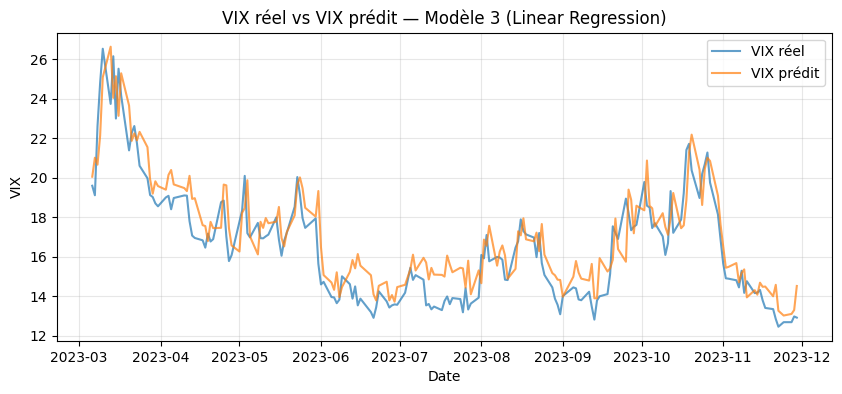

In [75]:
cv_rmse = -cross_val_score(
    model3_linear,
    X_train_scaled_3,
    y_train_3,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)

print("RMSE CV (folds):", cv_rmse)
print("RMSE CV moyenne:", cv_rmse.mean())
print("RMSE CV écart-type:", cv_rmse.std())

plot_real_vs_pred(
    y_test_3,
    y_pred_linear3,
    "VIX réel vs VIX prédit — Modèle 3 (Linear Regression)"
)

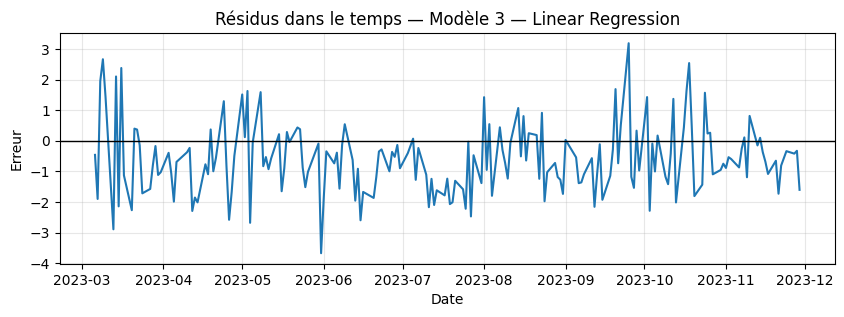

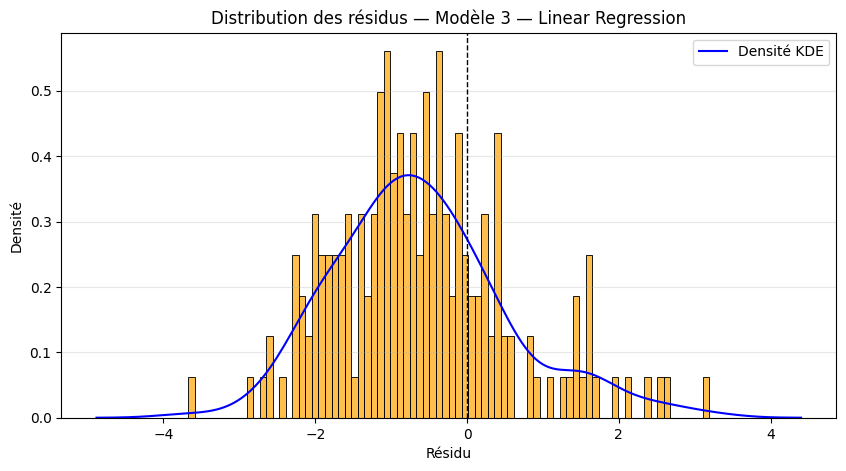

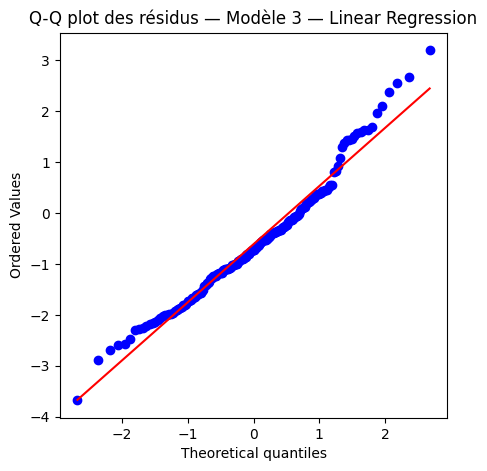

In [76]:
residuals = y_test_3 - y_pred_linear3

plot_residuals_diagnostics(residuals, "Modèle 3 — Linear Regression")

2/ Ridge Regression Model

In [77]:
# Hyperparameter grid (controls the bias–variance trade-off)
param_grid = {
    "alpha": np.logspace(-3, 2, 30)  # 0.001 to 100
}

# Ridge regression model
ridge = Ridge()

# GridSearch optimizing RMSE only
grid_ridge = GridSearchCV(
    ridge,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Fit GridSearch
grid_ridge.fit(X_train_scaled_3, y_train_3)

# Collect results
results = pd.DataFrame(grid_ridge.cv_results_)

# Convert score back to positive RMSE
results["RMSE"] = -results["mean_test_score"]

# Keep useful columns
results = results[["param_alpha", "RMSE", "std_test_score"]]

# Sort by RMSE (best first)
results = results.sort_values("RMSE")

# Display top candidates (to be ranked later by R²)
print("Top RMSE models (to be ranked by R² next):")
print(results.head())

Top RMSE models (to be ranked by R² next):
    param_alpha      RMSE  std_test_score
29   100.000000  3.324862        1.699142
28    67.233575  3.366655        1.747170
27    45.203537  3.418009        1.780208
26    30.391954  3.473415        1.788074
25    20.433597  3.527960        1.763149


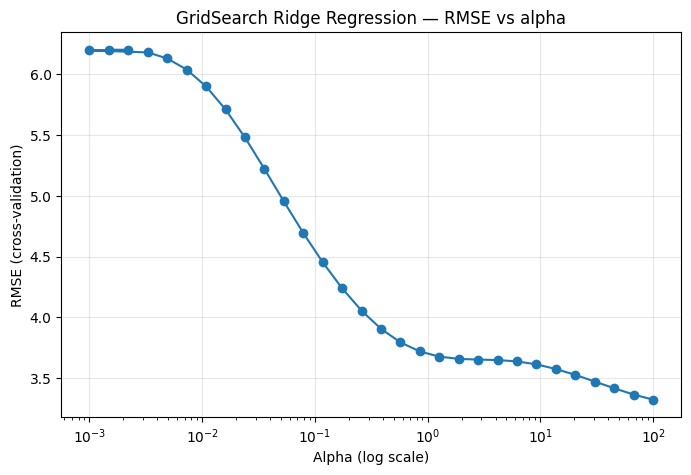

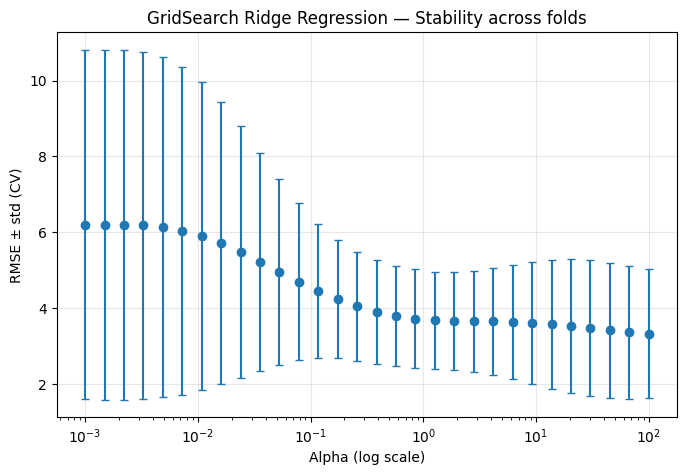

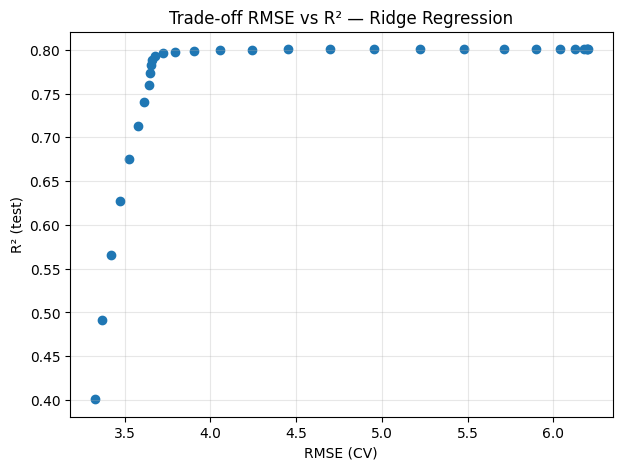

In [78]:
plot_gridsearch_diagnostics(
    results,
    model_class=Ridge,
    X_train_scaled=X_train_scaled_3,
    y_train=y_train_3,
    X_test_scaled=X_test_scaled_3,
    y_test=y_test_3,
    model_name="Ridge Regression"
)

In [79]:
# Ridge Regression — Model 3 (alpha selected via GridSearch)
model3_ridge = Ridge(alpha=100)
model3_ridge.fit(X_train_scaled_3, y_train_3)

y_pred_ridge3 = model3_ridge.predict(X_test_scaled_3)

MSE_ridge3 = mean_squared_error(y_test_3, y_pred_ridge3)
print("MSE Ridge Regression (Model 3, alpha=100): ", MSE_ridge3, "\n")

RMSE_ridge3 = np.sqrt(mean_squared_error(y_test_3, y_pred_ridge3))
print("RMSE :", RMSE_ridge3, "\n")

R2_ridge3 = r2_score(y_test_3, y_pred_ridge3)
print("R2 score: ", R2_ridge3)

MSE Ridge Regression (Model 3, alpha=100):  5.051574065791624 

RMSE : 2.247570703179685 

R2 score:  0.40093311497391504


It is not the best comparing to the ones before but it is the most stable one.

RMSE CV (folds): [6.33084388 2.41322996 4.06287777 1.98806468 1.82929412]
RMSE CV moyenne: 3.3248620805579767
RMSE CV écart-type: 1.69914200040396


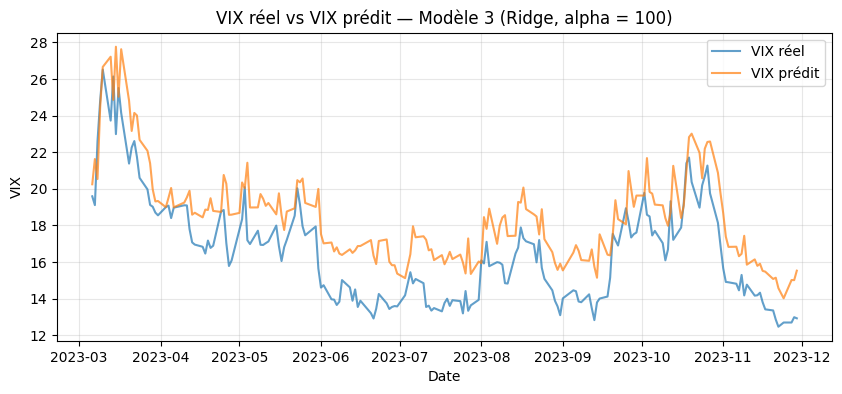

In [80]:
cv_rmse_ridge = -cross_val_score(
    model3_ridge,
    X_train_scaled_3,
    y_train_3,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)

print("RMSE CV (folds):", cv_rmse_ridge)
print("RMSE CV moyenne:", cv_rmse_ridge.mean())
print("RMSE CV écart-type:", cv_rmse_ridge.std())

plot_real_vs_pred(
    y_test_3,
    y_pred_ridge3,
    "VIX réel vs VIX prédit — Modèle 3 (Ridge, alpha = 100)"
)

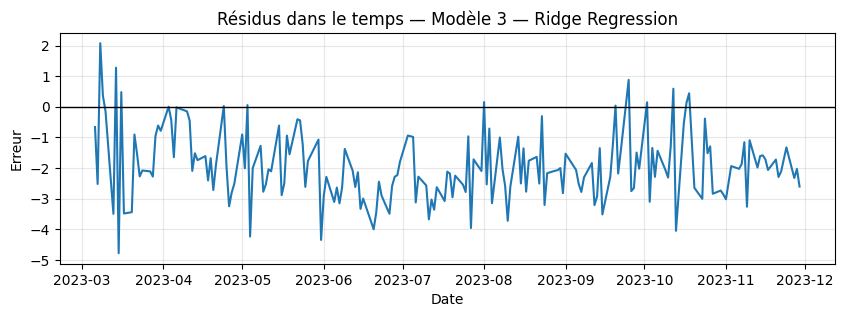

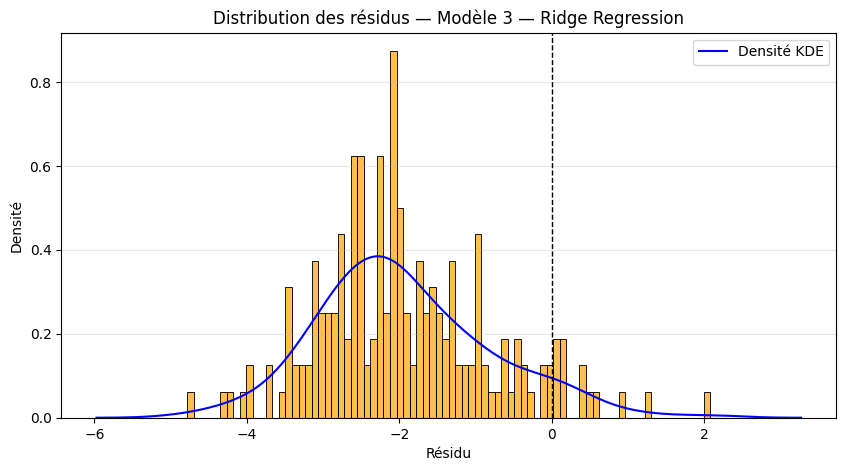

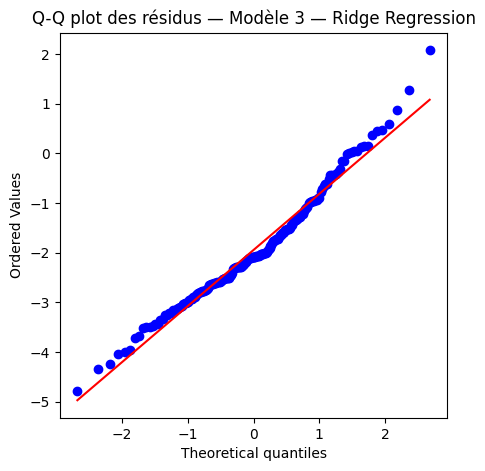

In [81]:
residuals_ridge = y_test_3 - y_pred_ridge3

plot_residuals_diagnostics(residuals_ridge, "Modèle 3 — Ridge Regression")

3/ Lasso Regression

In [82]:
# Hyperparameter grid (controls the bias–variance trade-off)
# Smaller alphas than Ridge because Lasso is more aggressive
param_grid = {
    "alpha": np.logspace(-4, 0, 30)  # 0.0001 to 1
}

# Lasso regression model
lasso = Lasso(max_iter=10000)

# GridSearch optimizing RMSE only
grid_lasso = GridSearchCV(
    lasso,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Fit GridSearch
grid_lasso.fit(X_train_scaled_3, y_train_3)

# Collect results
results_lasso = pd.DataFrame(grid_lasso.cv_results_)

# Convert score back to positive RMSE
results_lasso["RMSE"] = -results_lasso["mean_test_score"]

# Keep useful columns
results_lasso = results_lasso[["param_alpha", "RMSE", "std_test_score"]]

# Sort by RMSE (best first)
results_lasso = results_lasso.sort_values("RMSE")

# Display top candidates (to be ranked later by R²)
print("Top RMSE models (to be ranked by R² next):")
print(results_lasso.head())

Top RMSE models (to be ranked by R² next):
    param_alpha      RMSE  std_test_score
25     0.280722  2.230227        0.733592
24     0.204336  2.252079        0.833024
26     0.385662  2.286629        0.719706
23     0.148735  2.289970        0.906095
22     0.108264  2.330913        0.947247


In [83]:
# Lasso Regression — Model 3 (alpha selected via GridSearch)
model3_lasso = Lasso(alpha=0.280722, max_iter=10000)
model3_lasso.fit(X_train_scaled_3, y_train_3)

y_pred_lasso3 = model3_lasso.predict(X_test_scaled_3)

MSE_lasso3 = mean_squared_error(y_test_3, y_pred_lasso3)
print("MSE Lasso Regression (Model 3, alpha=0.280722): ", MSE_lasso3, "\n")

RMSE_lasso3 = np.sqrt(mean_squared_error(y_test_3, y_pred_lasso3))
print("RMSE :", RMSE_lasso3, "\n")

R2_lasso3 = r2_score(y_test_3, y_pred_lasso3)
print("R2 score: ", R2_lasso3)

MSE Lasso Regression (Model 3, alpha=0.280722):  3.3088040696485037 

RMSE : 1.819011838787341 

R2 score:  0.6076084560277876


In [84]:
cv_rmse_lasso = -cross_val_score(
    model3_lasso,
    X_train_scaled_3,
    y_train_3,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)

print("RMSE CV (folds):", cv_rmse_lasso)
print("RMSE CV moyenne:", cv_rmse_lasso.mean())
print("RMSE CV écart-type:", cv_rmse_lasso.std())

RMSE CV (folds): [3.45809405 1.98303456 2.53872685 1.89858624 1.27269612]
RMSE CV moyenne: 2.2302275622043557
RMSE CV écart-type: 0.7335918101634247


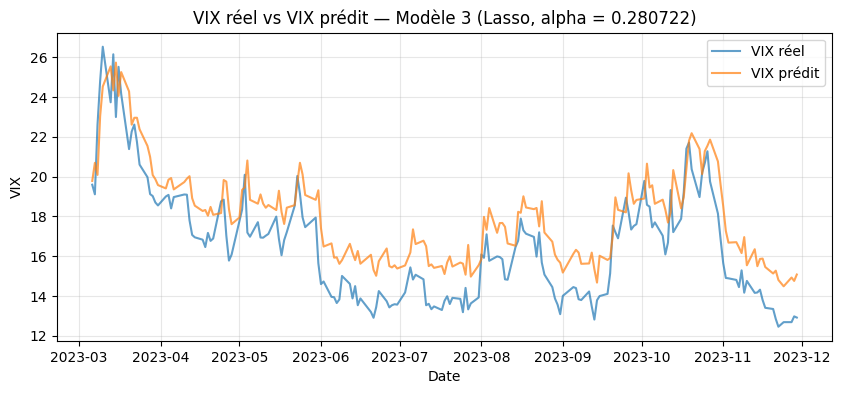

In [85]:
plot_real_vs_pred(
    y_test_3,
    y_pred_lasso3,
    "VIX réel vs VIX prédit — Modèle 3 (Lasso, alpha = 0.280722)"
)

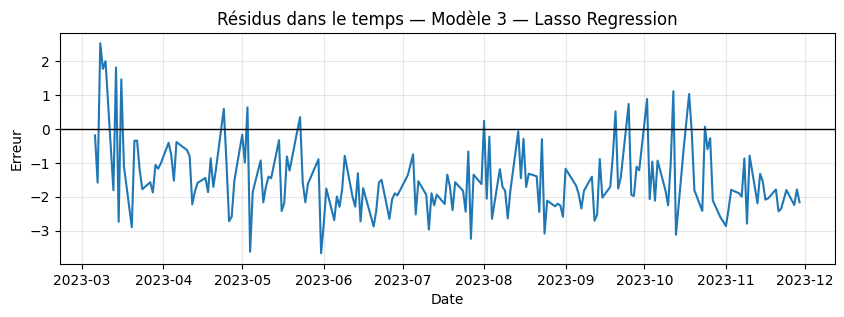

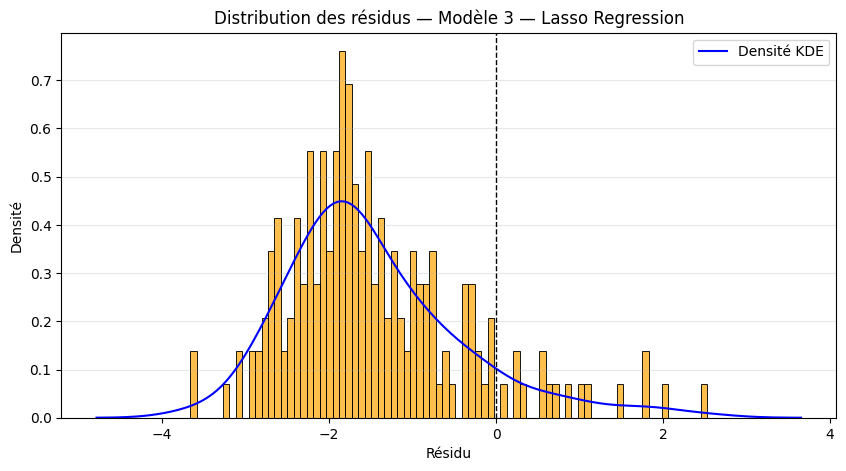

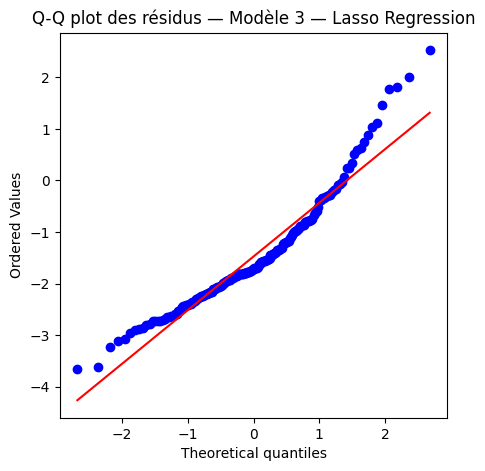

In [86]:
residuals_lasso = y_test_3 - y_pred_lasso3

plot_residuals_diagnostics(residuals_lasso, "Modèle 3 — Lasso Regression")

Although the linear regression achieves the best test performance, the Lasso model is selected because it is significantly more stable across time, better handles regime changes, and captures market stress dynamics with lower sensitivity to noise — which is crucial in financial applications.

In [87]:
final_model=model3_lasso